# Transformation Equations:  ComCam DP1 <--> GAIA DR3

***DOUBLE CHECK THE ORDER OF THE CONSTANTS IN THE EQUATIONS, ESP. FOR NORDER = 3***

_Douglas L. Tucker_, _Christina Adair_

_2025.06.30_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## 2.  Input Parameters

In [2]:
# ComCam-->Gaia DR3 (toComCam=False) or Gaia DR3-->ComCam (toComCam=True)...
#toComCam = True
toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    # If Gaia-->ComCam, then the mag and color to fit against are Gaia...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_ComCam':'G_gaia', 'r_ComCam':'G_gaia', 'i_ComCam':'G_gaia', 'z_ComCam':'G_gaia', 'y_ComCam':'G_gaia'}
    # Color to fit against...
    color_name_1_dict = {'g_ComCam':'BP_RP_gaia', 'r_ComCam':'BP_RP_gaia', 'i_ComCam':'BP_RP_gaia', 'z_ComCam':'BP_RP_gaia', 'y_ComCam':'BP_RP_gaia'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_ComCam':'$(BP-RP)_{gaia}$', 'r_ComCam':'$(BP-RP)_{gaia}$', 'i_ComCam':'(BP-RP)_{gaia}', 'z_ComCam':'$(BP-RP)_{gaia}$', 'y_ComCam':'$(BP-RP)_{gaia}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...
    color_limits_1_dict = {'g_ComCam':[-10.,10.], 
                           'r_ComCam':[-10.,10.], 
                           'i_ComCam':[-10.,10.],
                           'z_ComCam':[-10.,10.],
                           'y_ComCam':[-10.,10.]}
 
else:
    # List of Gaia bands on which to run the transform fit...
    bandList = ['G_gaia', 'BP_gaia', 'RP_gaia' ]
    # If ComCam-->Gaia, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    #matchBand_dict = {'G_gaia':'r_ComCam', 'BP_gaia':'g_ComCam', 'RP_gaia':'r_ComCam'}
    matchBand_dict = {'G_gaia':'g_ComCam', 'BP_gaia':'g_ComCam', 'RP_gaia':'r_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'G_gaia':'gi_ComCam', 'BP_gaia':'gi_ComCam', 'RP_gaia':'gi_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'G_gaia':'$(g-i)_{ComCam}$', 'BP_gaia':'$(g-i)_{ComCam}$', 'RP_gaia':'$(g-i)_{ComCam}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...    
    color_limits_1_dict = {'G_gaia':[-10.,10.], 
                           'BP_gaia':[-10.,10.], 
                           'RP_gaia':[-10.,10.]}


# Order of polynomial fits...
norder = 2

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# ComCam data
collection='LSSTComCam/DP1'
repo = 'dp1'
skymap = 'lsst_cells_v1'
instrument = 'LSSTComCam'

# Gaia DR3 TAP service
gaia_tap_url = 'https://gaia.aip.de/tap'

#use match file?
useMatchFile = False

## Name of the match file in matchDir
matchFile = './match_ComCam_GAIA_DR3_ECDFS.csv'
#matchFile = './match_ComCam_GAIA_DR3_47Tuc.csv'

# Base name of fit results output file...
if toComCam:
    #resultsFileBaseName = 'transInterp.GaiaDR3_to_ComCam_ECDFS'
    resultsFileBaseName = 'transInterp.GaiaDR3_to_ComCam_47Tuc'
else:
    #resultsFileBaseName = 'transInterp.ComCam_to_GaiaDR3_ECDFS'
    resultsFileBaseName = 'transInterp.ComCam_to_GaiaDR3_47Tuc'

# Base name of QA plot output files...
if toComCam:
    #qaFileBaseName = 'qaPlot.GaiaDR3_to_ComCam_ECDFS.interp.fit'
    qaFileBaseName = 'qaPlot.GaiaDR3_to_ComCam_47Tuc.interp.fit'
else:
    #qaFileBaseName = 'qaPlot.GaiaDR3_to_ComCam_ECDFS.interp.fit'
    qaFileBaseName = 'qaPlot.GaiaDR3_to_ComCam_47Tuc.interp.fit'

# Base name of fit results output file...
#if toComCam:
#    resultsFileBaseName = 'transFit.GaiaDR3_to_ComCam'
#else:
#    resultsFileBaseName = 'transFit.ComCam_to_GaiaDR3'

# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.GaiaDR3_to_ComCam.fit'
else:
    qaFileBaseName = 'qaPlot.ComCam_to_GaiaDR3.fit'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }


## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Create a new dataframe with matches
    matches = df1[mask].copy()
    matches['match_idx'] = idx[mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        matches[f'match_{col}'] = df2.loc[idx[mask], col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~mask]

    return matches, unmatched

In [5]:
def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plotText, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})
    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    #plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.text(0.00,0.40,plotText,fontsize=12)
    plt.axis('off')

    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    if len(dmag) < 1000:
        plt.scatter(color1, dmag, alpha=0.75)
        #hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno_r')
    else:
        hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    if len(dmag) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)

    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    if len(res) < 100:
        plt.hist(res,bins=10)
    else:
        plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224)
    if len(res) < 1000:
        plt.scatter(color1, res, alpha=0.75)
        #hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno_r')
    else:
        hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    if len(res) >= 1000:
        cb = plt.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################
      

In [6]:
# Kudos to Claude-3.5-Sonnet for improving on old outlier rejection code...

def poly_fit_with_sigma_clip(x, y, degree=1, sigma=3.0, maxiters=5):
    """
    Perform polynomial fit with iterative sigma clipping
    
    Parameters:
    -----------
    x : array-like
        Independent variable
    y : array-like 
        Dependent variable
    degree : int
        Degree of polynomial fit
    sigma : float
        Sigma clipping threshold
    maxiters : int
        Maximum number of sigma clipping iterations
        
    Returns:
    --------
    coeffs : array
        Polynomial coefficients
    mask : array
        Boolean mask indicating non-clipped points
    rms : float
        RMS of residuals
    """

    # Import relevant modules
    import numpy as np
    from astropy.stats import sigma_clip
    
    # Initial fit using all points
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.ones_like(x, dtype=bool)
    
    for _ in range(maxiters):
        print(len(x[mask]), len(y[mask]), len(mask))

        # Fit polynomial to non-masked points
        coeffs, cov = np.polyfit(x[mask], y[mask], degree, cov=True)
        
        # Calculate residuals
        yfit = np.polyval(coeffs, x)
        residuals = y - yfit
        
        # Update mask with sigma clipping
        new_mask = ~sigma_clip(residuals, sigma=sigma).mask
        
        # Check for convergence
        if np.array_equal(mask, new_mask):
            break
        
        mask = new_mask
    
    # Calculate final RMS
    final_residuals = y[mask] - np.polyval(coeffs, x[mask])
    rms = np.sqrt(np.mean(final_residuals**2))

    print(len(x[mask]), len(y[mask]), len(mask))

    # Calculate coefficient errors from diagonal of covariance matrix
    coeff_errors = np.sqrt(np.diag(cov))
        
    return coeffs, coeff_errors, x[mask], y[mask], final_residuals, rms


## X. Read in Matched Catalog

In [7]:
#matchFile = os.path.join(matchDir,matchFile)
#print(matchFile)

In [8]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


In [9]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    tab

In [10]:
if useMatchFile:
    matches = tab.to_pandas()
    matches

## 4. Query ComCam Catalog

In [11]:
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler = Butler(repo, collections=collection)
    skybutler = Butler(repo, collections=collection, skymap=skymap)

In [12]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [13]:
# Download stars from the ECDFS...
if not useMatchFile:
    comcam_stars_list = []

    for tractId in tract_list:

        if tract_dict[tractId] != 'ECDFS':
        #if tract_dict[tractId] != '47 Tuc':
            continue

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                    collections=[collection],
                                    parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")
    
            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 
    
        # Catch any exception
        except Exception as e:
    
            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")


4849 ECDFS
Number of objects: 58807
Number of stars: 2433
5063 ECDFS
Number of objects: 206560
Number of stars: 7859
4848 ECDFS
Number of objects: 32195
Number of stars: 1318
Total number of stars: 11610


In [14]:
if not useMatchFile:
    display(comcam_stars_all)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,4849,ECDFS,53.305439,-28.694426,102.622742,362.713531,202.669632,746.471375,NaN,False,...,-4887.167480,1090.719849,NaN,True,NaN,NaN,NaN,NaN,NaN,True
1,4849,ECDFS,53.271986,-28.674615,13477.228516,417.236908,14691.198242,766.648560,0.0,False,...,48194.140625,787.312744,0.0,False,NaN,NaN,NaN,NaN,NaN,True
2,4849,ECDFS,53.303878,-28.716939,NaN,NaN,207.161087,inf,NaN,True,...,341.315216,19.313709,NaN,True,NaN,NaN,NaN,NaN,NaN,True
3,4849,ECDFS,53.282122,-28.714891,15.933578,366.984955,39.616570,755.121948,NaN,False,...,341.310211,19.318277,NaN,True,NaN,NaN,NaN,NaN,NaN,True
4,4849,ECDFS,53.325036,-28.698507,NaN,NaN,207.160324,inf,NaN,True,...,3398.122803,1107.703125,NaN,True,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605,4848,ECDFS,52.489287,-28.301890,263.541107,499.560486,1331.339111,911.998169,NaN,False,...,17450.337891,537.006653,0.0,False,11394.498047,1427.051514,17467.615234,3351.327637,1.0,False
11606,4848,ECDFS,52.484202,-28.293377,563.121399,502.916504,1660.746826,909.509949,NaN,False,...,2815.898682,570.594543,0.0,False,3747.318848,1448.693115,9109.958984,3348.508301,NaN,False
11607,4848,ECDFS,52.508069,-28.274509,3934.830322,285.058014,5220.767578,552.559998,1.0,False,...,198803.078125,465.304047,0.0,False,222308.671875,1699.593018,222325.031250,3380.520264,0.0,False
11608,4848,ECDFS,52.512609,-28.272698,3119.956055,287.195923,3282.177979,525.901978,NaN,False,...,591515.062500,497.266327,0.0,False,757014.000000,2229.701660,755376.500000,3537.615967,0.0,False


In [15]:
# Find the bounding (ra,dec)'s for the ComCam EDFS field: 
if not useMatchFile:
    ra_min = comcam_stars_all.coord_ra.min()
    ra_max = comcam_stars_all.coord_ra.max()
    dec_min = comcam_stars_all.coord_dec.min()
    dec_max = comcam_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

52.407997082811164 53.874488721158265 -28.716939392158658 -27.501464859634126


## 5. Query GAIA DR3 Catalog

In [16]:
# Invoke TAP service to GAIA DR3 data....
if not useMatchFile:
    gaia_tap = pyvo.dal.TAPService(gaia_tap_url)

In [17]:
# Query the GAIA DR3 stars in the area of the ComCom EDFS field.
#  Since the GAIA DR3 TAP service seems to have limits on the number
#  of rows downloaded by query, split the query into multiple queries
#  by RA, DEC...

# Kudos to Claude-3.5-Sonnet
if not useMatchFile:
    # Define the step size
    ra_step = 1.0
    dec_step = 1.0

    # Create arrays of ra and dec values
    ra_edges = np.arange(ra_min, ra_max + ra_step, ra_step)
    dec_edges = np.arange(dec_min, dec_max + dec_step, dec_step)

    print(len(ra_edges), len(dec_edges), len(ra_edges)*len(dec_edges))

    # Initialize an empty list to store all results
    all_results = []
    i=0
    j=0
    # Loop through ra and dec ranges
    for ra in ra_edges[:-1]: 
        for dec in dec_edges[:-1]:
            #if i > 2 or j > 2: 
                #continue
            print(i, j)
            # Define the polygon corners for this small chunk
            ra_chunk_min = ra
            ra_chunk_max = min(ra + ra_step, ra_max)
            dec_chunk_min = dec
            dec_chunk_max = min(dec + dec_step, dec_max)
        
            query = """
            SELECT 
                source_id, ra, dec, parallax, parallax_error,
                pmra, pmra_error, pmdec, pmdec_error,
                phot_g_mean_mag, 1.086/phot_g_mean_flux_over_error as phot_g_mean_mag_error, 
                phot_bp_mean_mag, 1.086/phot_bp_mean_flux_over_error as phot_bp_mean_mag_error, 
                phot_rp_mean_mag, 1.086/phot_rp_mean_flux_over_error as phot_rp_mean_mag_error,
                bp_rp
                FROM gaiadr3.gaia_source_lite
            WHERE 
                ra>=%f AND ra<%f AND dec>=%f AND dec<%f  
                AND parallax_over_error > 5 
                AND ruwe < 1.4  
                AND phot_g_mean_flux_over_error > 5  
                AND phot_rp_mean_flux_over_error > 5
                AND phot_bp_mean_flux_over_error > 5
            """ % (ra_chunk_min, ra_chunk_max, 
                   dec_chunk_min, dec_chunk_max)

            #print(query)
            print("RA range: ", ra_chunk_min, ra_chunk_max, "DEC range: ", dec_chunk_min, dec_chunk_max, "\n")
        
            try:
                # Run the query
                result = gaia_tap.run_sync(query)
                # Convert to pandas dataframe and append to list
                if len(result) > 0:
                    all_results.append(result.to_table().to_pandas())
                print(len(result))
            except Exception as e:
                print(f"Error in query for ra={ra}, dec={dec}: {e}")
                continue

            j=j+1

        i=i+1

    # Combine all results into a single dataframe
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
    
        # Remove any potential duplicates that might occur at chunk boundaries
        combined_df = combined_df.drop_duplicates()
    else:
        combined_df = pd.DataFrame()

    # De-fragment DataFrame...
    combined_df = combined_df.copy()

    print(f"Total number of objects found: {len(combined_df)}")

3 3 9
0 0
RA range:  52.407997082811164 53.407997082811164 DEC range:  -28.716939392158658 -27.716939392158658 

929
0 1
RA range:  52.407997082811164 53.407997082811164 DEC range:  -27.716939392158658 -27.501464859634126 

198
1 2
RA range:  53.407997082811164 53.874488721158265 DEC range:  -28.716939392158658 -27.716939392158658 

437
1 3
RA range:  53.407997082811164 53.874488721158265 DEC range:  -27.716939392158658 -27.501464859634126 

98
Total number of objects found: 1662


In [18]:
if not useMatchFile:
    display(combined_df)

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_mean_mag,phot_rp_mean_mag_error,bp_rp
0,5057119383094674304,53.373438,-28.715488,1.707377,0.012273,0.368578,0.009148,6.911621,0.013369,13.457238,0.000139,13.790290,0.000523,12.961813,0.000442,0.828477
1,5057119451814150784,53.368392,-28.703033,1.293000,0.060299,4.688299,0.042033,-3.616474,0.065350,16.965731,0.000478,17.706600,0.004710,16.142498,0.002802,1.564102
2,5057294652120320640,52.784835,-28.710643,0.419048,0.072446,8.334354,0.053041,4.200369,0.082784,17.593536,0.000648,18.097292,0.007863,16.950895,0.005065,1.146397
3,5057294823919012608,52.764001,-28.702607,0.681647,0.021790,9.564491,0.015762,-2.709829,0.022514,15.123405,0.000204,15.418921,0.001176,14.659840,0.001066,0.759081
4,5057294922701551104,52.764300,-28.695157,0.818875,0.111071,-3.025615,0.080036,-9.971361,0.119700,18.264053,0.000991,19.085039,0.019334,17.414806,0.007324,1.670233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,5081539016655057408,53.802120,-27.525908,6.064447,0.169934,-12.776783,0.098431,-8.472868,0.164383,18.525040,0.001089,20.470087,0.056034,17.210035,0.005143,3.260052
1658,5081539398909698432,53.776977,-27.527194,1.648654,0.196395,-7.501527,0.121515,-22.802809,0.201046,18.918049,0.001281,20.224453,0.042235,17.782160,0.010553,2.442293
1659,5081539708146439936,53.725270,-27.511957,2.995539,0.050749,24.442421,0.031047,-5.667120,0.050458,16.623642,0.000378,17.809296,0.006360,15.546162,0.001485,2.263134
1660,5081539811225651328,53.805255,-27.505535,1.739434,0.015507,9.494795,0.009107,-4.469837,0.015221,13.882575,0.000117,14.233747,0.000502,13.362411,0.000396,0.871335


## 6. Match ComCam and GAIA DR3 stars

In [19]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, combined_df, 
                                              'coord_ra', 'coord_dec', 
                                              'ra', 'dec')

In [20]:
if not useMatchFile:
    display(matches)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,match_pmra_error,match_pmdec,match_pmdec_error,match_phot_g_mean_mag,match_phot_g_mean_mag_error,match_phot_bp_mean_mag,match_phot_bp_mean_mag_error,match_phot_rp_mean_mag,match_phot_rp_mean_mag_error,match_bp_rp
5,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,0.134262,-10.390606,0.202554,18.697474,0.001515,19.924204,0.059806,17.573822,0.010280,2.350382
13,4849,ECDFS,53.208027,-28.690324,NaN,NaN,349.433563,249.765244,NaN,True,...,0.042778,2.061373,0.062725,17.038923,0.000497,17.938637,0.007362,16.109447,0.003046,1.829189
14,4849,ECDFS,53.224044,-28.683869,103001.476562,712.056396,102068.171875,961.282898,0.0,False,...,0.035362,1.676630,0.053901,16.789101,0.000430,17.196135,0.004045,16.225092,0.003066,0.971043
16,4849,ECDFS,53.205228,-28.676868,681.216919,401.955627,2.376565,820.792542,0.0,False,...,0.167899,0.479374,0.275214,19.265032,0.001972,20.917788,0.078785,18.001234,0.011948,2.916553
49,4849,ECDFS,53.513166,-28.594275,NaN,NaN,113.762482,11.487873,NaN,True,...,0.022799,-49.154572,0.031540,15.684342,0.000261,16.414009,0.002217,14.853327,0.001354,1.560682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,4848,ECDFS,52.531583,-28.278675,6529.918945,256.699432,5726.226074,477.782898,1.0,False,...,0.061802,-9.662717,0.090608,17.838869,0.000694,18.881178,0.012803,16.840034,0.003758,2.041143
11583,4848,ECDFS,52.671060,-28.279813,931.075562,114.185661,1729.474121,221.764725,NaN,False,...,0.191915,12.263063,0.298915,19.479137,0.002022,20.823980,0.077067,18.326042,0.016195,2.497938
11585,4848,ECDFS,52.575580,-28.272697,1698.876465,195.230972,2023.701172,365.644287,1.0,False,...,0.137194,0.515705,0.209781,18.989882,0.001588,20.568155,0.053906,17.781967,0.007813,2.786188
11597,4848,ECDFS,52.640065,-28.265870,696.014832,152.253082,1364.908691,283.501862,1.0,False,...,0.212114,-44.451007,0.332056,19.629303,0.002378,21.094685,0.094104,18.422266,0.022825,2.672419


In [21]:
if not useMatchFile:
    matches.to_csv(matchFile, index=False)

##  7. Add ABmag Columns to Matched Catalog Data Frame

In [22]:
# Copy matches to df...
df = matches.copy()

In [23]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = ((df[flux_col] > 0) & (df[flux_col].notna()))

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10



In [24]:
df

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr
5,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,20.367268,0.003905,19.142454,0.002780,17.987560,0.001771,17.489765,0.002416,-9999.000000,-9999.000000
13,4849,ECDFS,53.208027,-28.690324,NaN,NaN,349.433563,249.765244,NaN,True,...,18.370285,0.001412,17.021061,0.004462,16.486149,0.000571,16.214436,0.000546,-9999.000000,-9999.000000
14,4849,ECDFS,53.224044,-28.683869,103001.476562,712.056396,102068.171875,961.282898,0.0,False,...,17.308290,0.000842,16.745222,0.000817,16.591869,0.000535,16.517895,0.000700,-9999.000000,-9999.000000
16,4849,ECDFS,53.205228,-28.676868,681.216919,401.955627,2.376565,820.792542,0.0,False,...,21.600529,0.009291,20.181971,0.007820,18.501892,0.001333,17.755005,0.001143,17.406319,0.005216
49,4849,ECDFS,53.513166,-28.594275,NaN,NaN,113.762482,11.487873,NaN,True,...,16.738405,0.001256,15.681138,0.000519,15.212702,0.000347,15.148424,0.000721,14.874872,0.001099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,4848,ECDFS,52.531583,-28.278675,6529.918945,256.699432,5726.226074,477.782898,1.0,False,...,19.325327,0.001446,18.036779,0.000549,17.223074,0.000465,16.862961,0.000572,16.684370,0.003096
11583,4848,ECDFS,52.671060,-28.279813,931.075562,114.185661,1729.474121,221.764725,NaN,False,...,21.442848,0.002536,20.098104,0.000969,18.748882,0.000494,18.150120,0.000567,17.858498,0.002527
11585,4848,ECDFS,52.575580,-28.272697,1698.876465,195.230972,2023.701172,365.644287,1.0,False,...,20.994751,0.003177,19.725372,0.000919,18.257153,0.000563,17.600180,0.000573,17.289173,0.003314
11597,4848,ECDFS,52.640065,-28.265870,696.014832,152.253082,1364.908691,283.501862,1.0,False,...,21.852844,0.003848,20.422436,0.001268,18.856869,0.000601,18.176399,0.000609,17.868521,0.002568


In [25]:
df.columns

Index(['tractId', 'field', 'coord_ra', 'coord_dec', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'match_idx',
       'separation_arcsec', 'match_source_id', 'match_ra', 'match_dec',
       'match_parallax', 'match_parallax_error', 'match_pmra',
       'match_pmra_error', 'match_pmdec', 'match_pmdec_error',
       'match_phot_g_mean_mag', 'match_phot_g_mean_mag_error',
       'match_phot_bp_mean_mag', 'm

In [26]:
# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'match_phot_g_mean_mag':'G_gaia',
                   'match_phot_g_mean_mag_error':'G_err_gaia', 
                   'match_phot_bp_mean_mag':'BP_gaia',
                   'match_phot_bp_mean_mag_error':'BP_err_gaia',
                   'match_phot_rp_mean_mag':'RP_gaia',
                   'match_phot_rp_mean_mag_error':'RP_err_gaia', 
                   'match_bp_rp':'BP_RP_gaia'
                  },inplace=True)

df.head(5)

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,g_ComCam,g_err_ComCam,r_ComCam,r_err_ComCam,i_ComCam,i_err_ComCam,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam
5,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,20.367268,0.003905,19.142454,0.002780,17.987560,0.001771,17.489765,0.002416,-9999.000000,-9999.000000
13,4849,ECDFS,53.208027,-28.690324,NaN,NaN,349.433563,249.765244,NaN,True,...,18.370285,0.001412,17.021061,0.004462,16.486149,0.000571,16.214436,0.000546,-9999.000000,-9999.000000
14,4849,ECDFS,53.224044,-28.683869,103001.476562,712.056396,102068.171875,961.282898,0.0,False,...,17.308290,0.000842,16.745222,0.000817,16.591869,0.000535,16.517895,0.000700,-9999.000000,-9999.000000
16,4849,ECDFS,53.205228,-28.676868,681.216919,401.955627,2.376565,820.792542,0.0,False,...,21.600529,0.009291,20.181971,0.007820,18.501892,0.001333,17.755005,0.001143,17.406319,0.005216
49,4849,ECDFS,53.513166,-28.594275,NaN,NaN,113.762482,11.487873,NaN,True,...,16.738405,0.001256,15.681138,0.000519,15.212702,0.000347,15.148424,0.000721,14.874872,0.001099


In [27]:
df.columns

Index(['tractId', 'field', 'RA_ComCam', 'DEC_ComCam', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'match_idx',
       'separation_arcsec', 'match_source_id', 'match_ra', 'match_dec',
       'match_parallax', 'match_parallax_error', 'match_pmra',
       'match_pmra_error', 'match_pmdec', 'match_pmdec_error', 'G_gaia',
       'G_err_gaia', 'BP_gaia', 'BP_err_gaia', 'RP_gaia', 'RP_err_gaia',
       'BP_RP

## 8. Add Color Columns to Matched Catalog Data Frame

In [28]:
# Add color columns...
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

In [29]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## 9. Create Initial Mask

In [30]:
mask1 = (df["G_gaia"] > 0.) & (df["G_gaia"] < 30.)
mask2 = (df["BP_gaia"] > 0.) & (df["BP_gaia"] < 30.)
mask3 = (df["RP_gaia"] > 0.) & (df["RP_gaia"] < 30.)
mask4 = (df["G_err_gaia"] > 0.00) & (df["G_err_gaia"] <= 0.02)
mask5 = (df["BP_err_gaia"] > 0.00) & (df["BP_err_gaia"] <= 0.02)
mask6 = (df["RP_err_gaia"] > 0.00) & (df["RP_err_gaia"] <= 0.02)
mask_Gaia = mask1 & mask2 & mask3  & mask4 & mask5 & mask6

mask1 = df["g_ComCam"] > 0.
mask2 = df["r_ComCam"] > 0.
mask3 = df["i_ComCam"] > 0.
mask4 = df["z_ComCam"] > 0.
mask4 = df["i_ComCam"] > 0.
mask5 = df["y_ComCam"] > 0.
mask6 = df["g_err_ComCam"] <= 0.02
mask7 = df["r_err_ComCam"] <= 0.02
mask8 = df["i_err_ComCam"] <= 0.02
mask9 = df["z_err_ComCam"] <= 0.02
mask9 = df["i_err_ComCam"] <= 0.02
mask10 = df["y_err_ComCam"] <= 0.02
mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask = mask_Gaia & mask_ComCam


In [31]:
df

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam,gr_ComCam,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,dmag
5,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,17.489765,0.002416,-9999.000000,-9999.000000,1.224813,1.154894,0.497795,10016.490234,2.379707,-9999.0
13,4849,ECDFS,53.208027,-28.690324,NaN,NaN,349.433563,249.765244,NaN,True,...,16.214436,0.000546,-9999.000000,-9999.000000,1.349224,0.534912,0.271713,10015.214844,1.884136,-9999.0
14,4849,ECDFS,53.224044,-28.683869,103001.476562,712.056396,102068.171875,961.282898,0.0,False,...,16.517895,0.000700,-9999.000000,-9999.000000,0.563068,0.153353,0.073975,10015.517578,0.716421,-9999.0
16,4849,ECDFS,53.205228,-28.676868,681.216919,401.955627,2.376565,820.792542,0.0,False,...,17.755005,0.001143,17.406319,0.005216,1.418558,1.680079,0.746887,0.348686,3.098637,-9999.0
49,4849,ECDFS,53.513166,-28.594275,NaN,NaN,113.762482,11.487873,NaN,True,...,15.148424,0.000721,14.874872,0.001099,1.057267,0.468436,0.064278,0.273552,1.525703,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,4848,ECDFS,52.531583,-28.278675,6529.918945,256.699432,5726.226074,477.782898,1.0,False,...,16.862961,0.000572,16.684370,0.003096,1.288548,0.813705,0.360113,0.178591,2.102253,-9999.0
11583,4848,ECDFS,52.671060,-28.279813,931.075562,114.185661,1729.474121,221.764725,NaN,False,...,18.150120,0.000567,17.858498,0.002527,1.344744,1.349222,0.598763,0.291622,2.693966,-9999.0
11585,4848,ECDFS,52.575580,-28.272697,1698.876465,195.230972,2023.701172,365.644287,1.0,False,...,17.600180,0.000573,17.289173,0.003314,1.269379,1.468220,0.656973,0.311007,2.737598,-9999.0
11597,4848,ECDFS,52.640065,-28.265870,696.014832,152.253082,1364.908691,283.501862,1.0,False,...,18.176399,0.000609,17.868521,0.002568,1.430408,1.565567,0.680470,0.307878,2.995975,-9999.0


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [32]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## 11. Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
G_gaia
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

G_gaia [-10.0, 10.0] 1
G_gaia [-0.7, 3.0] 1
*********************************
0 -0.7 3.0
*********************************
mask_branch length (before):  462
dmag_branch length:   462
color1_branch length:   462
462 462 462
433 433 462
420 420 462
417 417 462
416 416 462
416 416 462
mask_branch length (after):  462
p_2 = -0.032769 ± 0.001068
p_1 = -0.610388 ± 0.003089
p_0 = -0.054389 ± 0.001917
G_gaia - g_ComCam = -0.054 + -0.610*$(g-i)_{ComCam}$ + -0.033*$(g-i)_{ComCam}$^2  [-0.7 < $(g-i)_{ComCam}$ <= 3.0] [rms: 0.008]

g_ComCam --> G_gaia

G_gaia - g_ComCam = -0.054 + -0.610*$(g-i)_{ComCam}$ + -0.033*$(g-i)_{ComCam}$^2  [-0.7 < $(g-i)_{ComCam}$ <= 3.0] [rms: 0.008]




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
BP_gaia
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

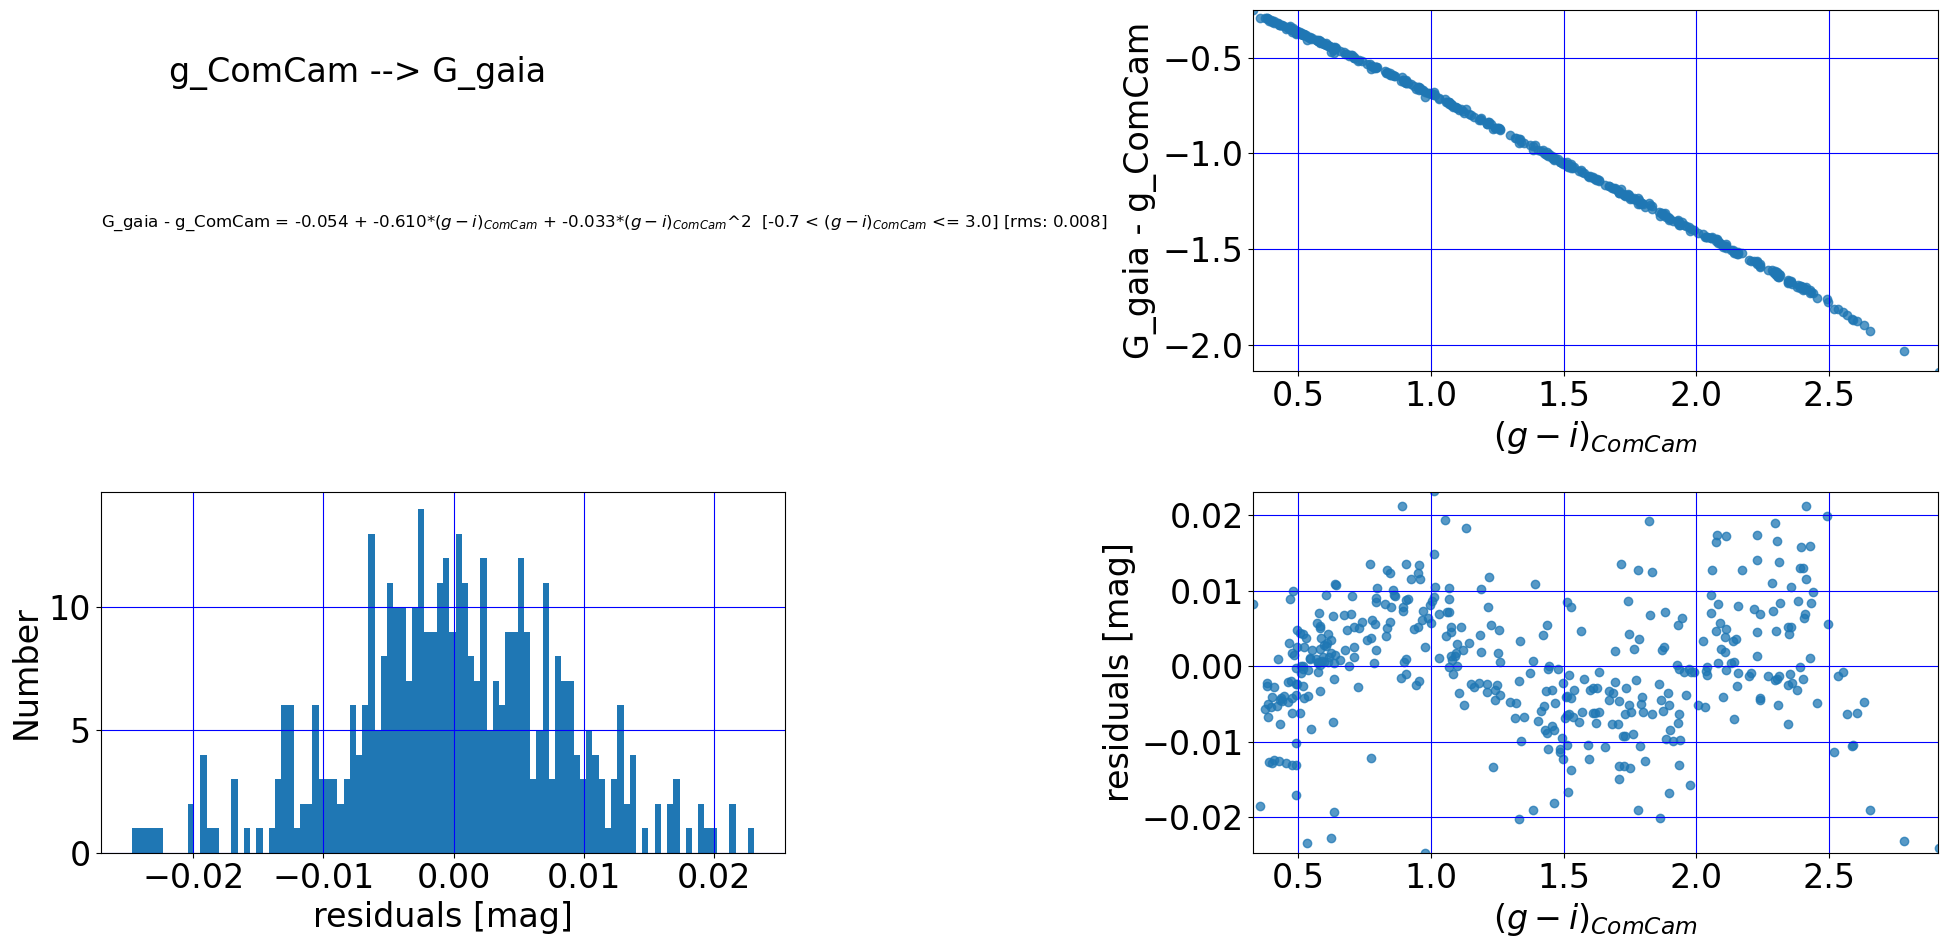

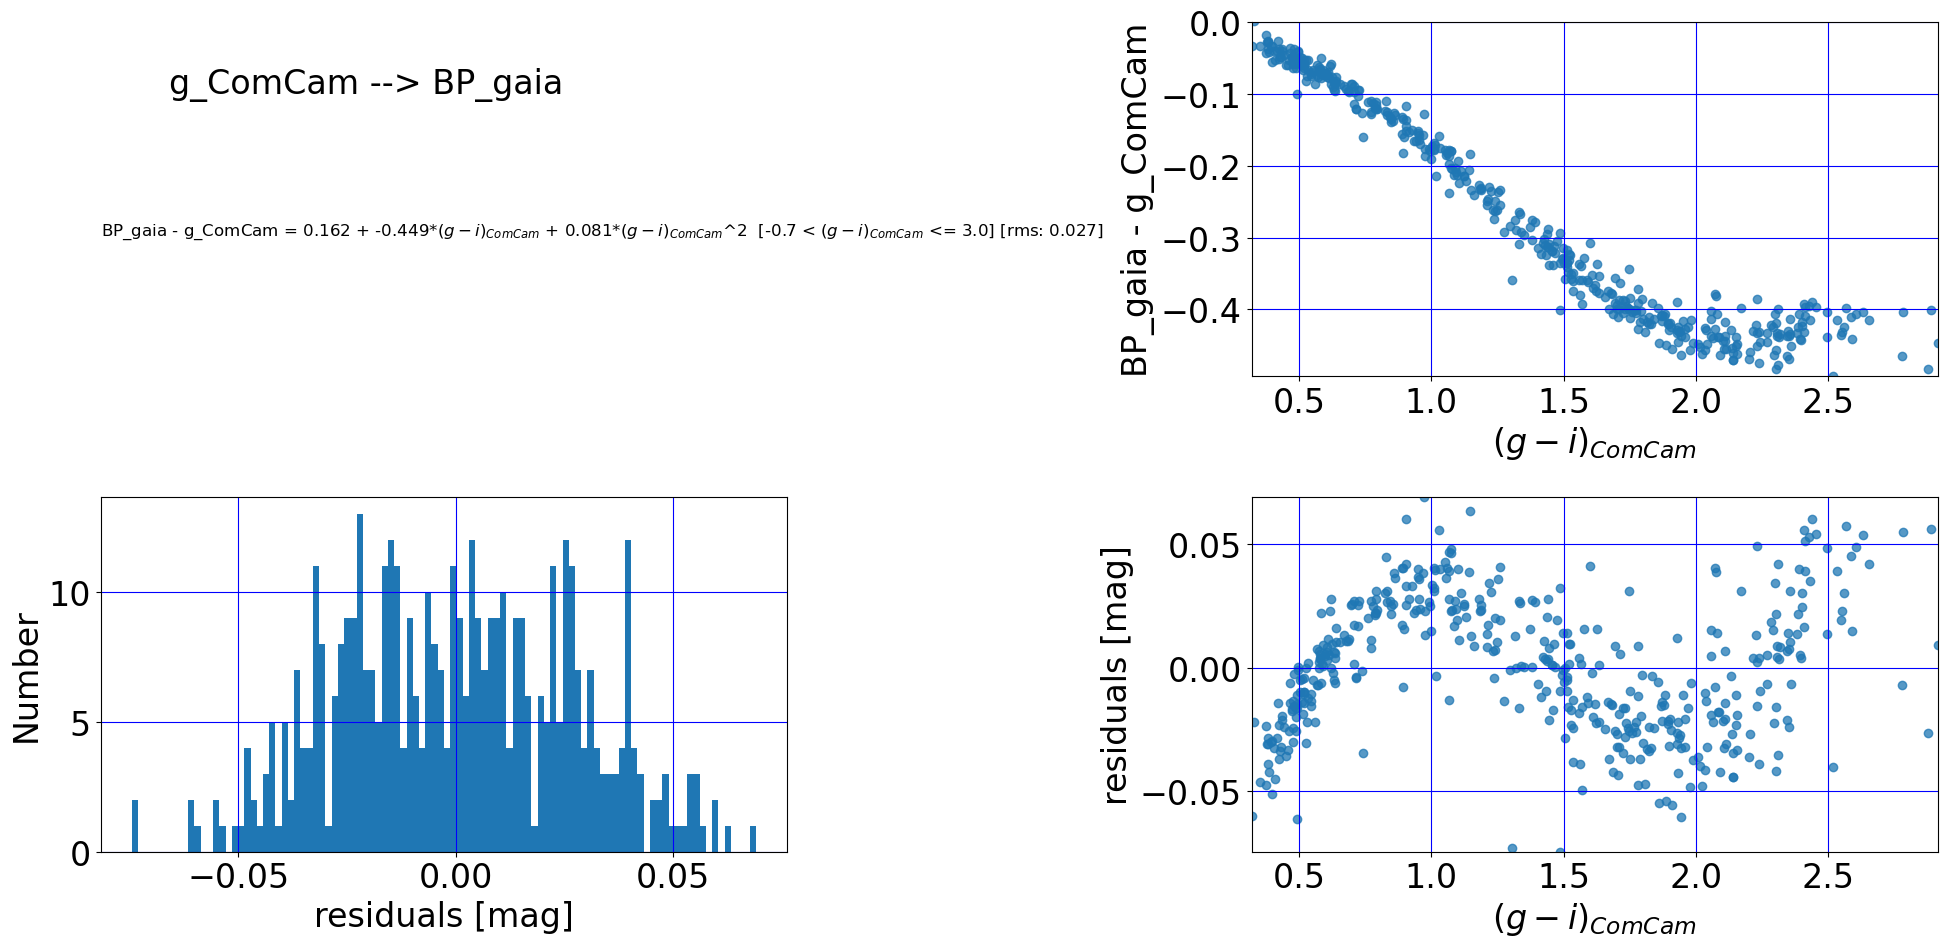

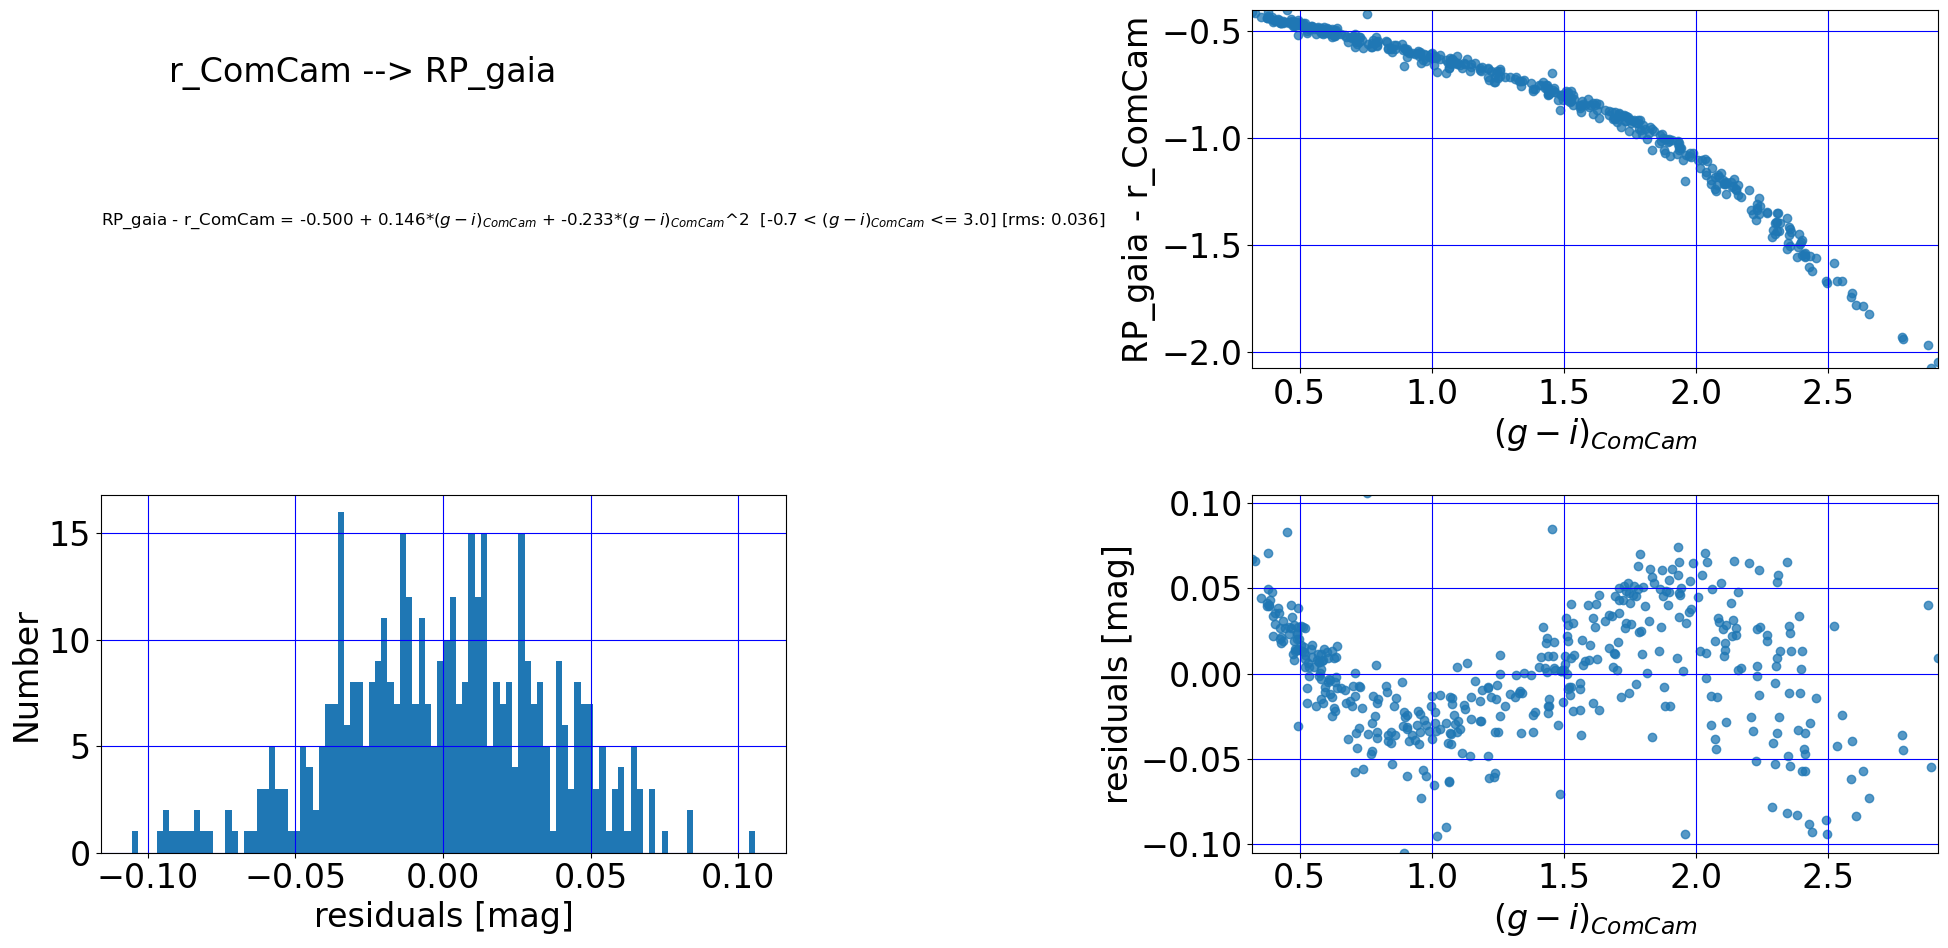

In [33]:
for band in bandList:

    print("")
    print("")
    print("")
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print(band)
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print("")

    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Create title/names for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagName = """%s - %s""" % (magName, magName_match)

    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band} - {$band}_match...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = ( abs(df['dmag']) <= 10. )
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) & (df[color_name_1].notna()) )
    mask = mask & mask1 & mask2

    # Apply the new mask to df...
    df = df[mask]

    ## Sanity check
    #df.plot(color_name_1, 'dmag', kind='scatter')

    # Calculate number of disjoint branches to fit...
    nbranches = len(color_limits_1_dict[band]) - 1
    if verbose > 0: print(band, color_limits_1_dict[band], nbranches)

    
    # Reset bluest color limit in bluest branch to color1_min
    #  and reddest color limit in reddest branch to color1_max, 
    #  after excluding above mask...
    #dftmp = df[mask]
    dftmp = df
    color1_desc = dftmp[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*(color1_desc['0.01%']-0.05))/10.
    color1_max = math.ceil(10*(color1_desc['99.99%']+0.05))/10.
    color_limits_1_dict[band][0] = color1_min
    color_limits_1_dict[band][nbranches] = color1_max
    if verbose > 0: print(band, color_limits_1_dict[band], nbranches)

    p_branch_list = []
    
    # Iterate, with sigma-clipping...
    df_list = []
    color1_list = []
    dmag_list = []
    res_list = []
    mask_list = []
    plot1Text = ''
    outputLine = ''
        
    for ibranch in range(nbranches):
            
        print('*********************************')
        print(ibranch, color_limits_1_dict[band][ibranch], color_limits_1_dict[band][ibranch+1])
        print('*********************************')

        # Extract branch...
        mask_branch = ( (df[color_name_1] >  color_limits_1_dict[band][ibranch]) & \
                        (df[color_name_1] <= color_limits_1_dict[band][ibranch+1]) )

        df_branch = df[mask_branch].copy()

        # ... and extract dmag's and color1's for this branch...
        dmag_branch   = df_branch.loc[:,'dmag']
        color1_branch = df_branch.loc[:,color_name_1]

        # If there are no valid colors on this branch, continue to next branch...
        if len(color1_branch) < 1:
            continue
                
        # Perform fit for each disjoint branch...
        print("mask_branch length (before): " , len(mask_branch))
        print("dmag_branch length:  ", len(dmag_branch))
        print("color1_branch length:  ", len(color1_branch))
        p_branch, perr_branch, color1_branch, dmag_branch, res_branch, stddev_branch = \
                                poly_fit_with_sigma_clip(color1_branch, dmag_branch, degree=norder)
        print("mask_branch length (after): " , len(mask_branch))

        # Print coefficients and estimated statistical errors in the coefficients
        for i, (p, perr) in enumerate(zip(p_branch, perr_branch)):
            print(f'p_{len(p_branch)-i-1} = {p:.6f} ± {perr:.6f}')
      
        # Prepare some text output for plots...
        #  Recall that np.polyfit returns the coefficients from highest order to lowest
        #  (This is opposite of the order the coefficients in older versions of this notebook
        #   that did not use np.polyfit for the polynomial fits)
        if norder == 1:
            plot1Text1 = """%s = %.3f + %.3f*%s [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[1], p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        elif norder == 2:
            plot1Text1 = """%s = %.3f + %.3f*%s + %.3f*%s^2  [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[2], p_branch[1], colorLabel_1, p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        elif norder == 3:
            plot1Text1 = """%s = %.3f + %.3f*%s + %.3f*%s^2 + %.3f*%s^3  \n[%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[3], p_branch[2], colorLabel_1, p_branch[1], colorLabel_1, p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        else:
            plot1Text1 = ''
            
        plot1Text = """%s\n%s""" % (plot1Text, plot1Text1)
        
        print(plot1Text1)                        
 
            
        # Append branch df and mask to the df_list and mask_list lists, respectively...
        #df_list.append(df_branch.copy())
        #mask_list.append(mask_branch.copy())
        color1_list.append(color1_branch.copy())
        dmag_list.append(dmag_branch.copy())
        res_list.append(res_branch.copy())
        mask_list.append(mask_branch.copy())
        
    # Concatenate the color1, dmag, res, and mask lists for all the branches...
    color1 = pd.Series(np.concatenate(color1_list))
    dmag = pd.Series(np.concatenate(dmag_list))
    res = pd.Series(np.concatenate(res_list))
    mask = pd.Series(np.concatenate(mask_list))
    
    # Calculate the standard deviation for the full piecewise fit...
    stddev = res.std()


    # Output best fits to screen...
    if verbose > 0:
        print("")
        print(title)
        print(plot1Text)
        print("")
    
    # Create QA plots...
    #res =  df.loc[:,'res']
    #dmag =  df.loc[:,'dmag']
    #color1 = df.loc[:,color_name_1]
    #stddev = df['res'].std()
    outputFileName = """%s.dmag_%s-%s.%s.norder%d.qa1.png""" % \
        (qaFileBaseName, magName, magName_match, color_name_1, norder)
    status = transform1ColorQAPlots1a(dmag, color1, res, norder, title, plot1Text, 
                                 dmagName, colorLabel_1, stddev, outputFileName)  
    
            

